# FHP program

## Libraries to import

In [136]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
animation.writers.list()  # Verificar los escritores disponibles
import pylab as pylab
from tqdm import tqdm

## Variables

In [137]:
rows = 25
columns = 25
n_particles = 10

## Initialize

In [138]:
# Aqui se crea el mesh.

#Esto crea una versión vectorizada de una función lambda que devuelve un objeto node con el parámetro False.
class node:
    def __init__(self, occupied):
        self.occupied = occupied

#Aquí, se crea un array de Numpy de tamaño (rows, columns) lleno de ceros, y luego 
#se convierte a tipo object. A continuación, se llena cada elemento del array con un objeto node(False).
def initialize(rows, columns):
    vectorized_object = np.vectorize(lambda obj: node(False))
    config = np.zeros((rows, columns)).astype(object) 
    config[:] = vectorized_object(config[:])
    
    # adding the walls:
    vectorized_object_wall = np.vectorize(lambda obj: node(True))
    
    #Se crea otra versión vectorizada de una función lambda que devuelve un objeto node(True). 
    #Esta se utiliza para establecer las "paredes" de la cuadrícula en los bordes (primera y última fila, 
    #primera y última columna) con nodos True.
    config[0, :] = vectorized_object_wall(config[0, :])
    config[rows-1, :] = vectorized_object_wall(config[rows-1, :])
    config[:, 0] = vectorized_object_wall(config[:, 0])
    config[:, columns-1] = vectorized_object_wall(config[:, columns-1])
     
    return config

# Función para observar y visualizar la cuadrícula:
def observe(config):
    vectorized_x = np.vectorize(lambda obj: obj.occupied)
    view_grid = vectorized_x(config)
    
    plt.figure(figsize = (10, 8))
    pylab.cla()
    pylab.imshow(view_grid, vmin = 0, vmax = 1, cmap = pylab.cm.binary)
    plt.show()

# Inicializar la cuadrícula y observarla:
config = initialize(rows, columns)
#observe(config)

## Cells class

The above class will represent each cell (hexagon) in the lattice. Note that Ni_s has six values to represent the six directions. If a node is set to be a wall, then it’s value will be 1 (while 0 means empty cell).

In [139]:
class node: 
    def __init__(self, wall):
        self.ni_s = [0, 0, 0, 0, 0, 0]
        self.wall = wall
        if not wall:
            self.occupied = 0
        else:
            self.occupied = 1

## Neighbords

write a function to get the neighbors of a cell given its coordinates in the lattice:
Note that I’m using a usual square lattice but to make it hexagonal, I’m only using six surrounding cells for each center cell.

In [140]:
""""
//Six directions + rest particles
//  a   b     |   0   1
//   \ /      |    \ /
//f --g-- c   |  5--6--2
//   / \      |    / \
//  e   d     |   4   3

a: top left
b: top right
c: right
f: left
e: bottom left
d: bottom right
"""

'"\n//Six directions + rest particles\n//  a   b     |   0   1\n//   \\ /      |    \\ /\n//f --g-- c   |  5--6--2\n//   / \\      |    / //  e   d     |   4   3\n\na: top left\nb: top right\nc: right\nf: left\ne: bottom left\nd: bottom right\n'

In [141]:
def get_neighbors(coordinates, config):
    row, column = coordinates
    neighbors = []
    neighbors.append([row, (column+2)%columns]) #right
    neighbors.append([(row-1)%rows, (column+1)%columns]) # top right
    neighbors.append([(row-1)%rows, (column-1)%columns]) #top left
    neighbors.append([row, (column-2)%columns]) #left
    neighbors.append([(row+1)%rows, (column-1)%columns]) #bottom left
    neighbors.append([(row+1)%rows, (column+1)%columns]) # bottom right
    
    return neighbors

## Fullfill the grid

write a function to fill the grid randomly with N particles:

In [142]:
#getting all possible coordinates and choosing N radnomly:
i_coords, j_coords = np.meshgrid(range(rows), range(columns), indexing='ij')
coordinate_grid = np.array([i_coords, j_coords])
all_coordinates = []
for i in range(1, rows-1):
    for j in range(1, columns-1):
        all_coordinates.append(list(coordinate_grid[:, i, j]))
        
        
def fill_random(N, config, d = False):
    # define coordenadas una serie random
    samples = random.sample(all_coordinates, N)
    #ocupa con particulas esas coordenadas random
    for row,column in samples:
        config[row, column].occupied = 1
        
        #obtiene las coordenadas de los vecinos de las celdas actuales.
        our_neighbors = get_neighbors([row, column], config)
        while True:
            if not d:
                direction = random.choice([i for i in range(6)]) #Elije para la celda ocupada una dirección random
            else:
                direction = d-1
            n_row, n_col = our_neighbors[direction] #Se fija la celda vecina en esa dirección
            if not config[n_row,n_col].wall:    # si no es una pared
                if config[n_row,n_col].occupied == 0:   # ni esta ocupado
                    # el bucle continua buscando hasta encontrar una dirección proxima que no 
                    # este ni oucpada, ni que sea una pared, y cuando la encuentra le asigna
                    # a la particula la dirección de ese hueco (d en el codigo, o Ni)
                    config[n_row,n_col].ni_s[direction]=1   
                    break
     
    return config

In [143]:
# visualization
my_grid = initialize(rows, columns)
my_grid = fill_random(50, my_grid)
#bserve(my_grid)

## Collision

### Double collision

$D_i = n_in_{i+3}(1-n_{i+1})(1-n_{i+2})(1-n_{i+4})(1-n_{i+5})$

If the quantity Dᵢ =1, then head-on collision is going to happen across i and i+3 and no particles will end up going in either of these two directions

In [144]:
"""
//  0         |       1
//   \ /      |    \ /
//  --g--     |   --6--
//   / \      |    / \
//      3     |   4   
"""

'\n//  0         |       1\n//   \\ /      |    \\ /\n//  --g--     |   --6--\n//   / \\      |    / //      3     |   4   \n'

### Triple Collision

$T_i = n_in_{i+2}n_{i+4}(1-n_{i+1})(1-n_{i+3})(1-n_{i+5})$

Similar to Dᵢ, Tᵢ is either 0 or 1 and indicates whether three-body collision happens.

### Collision factor

Its used to tell whether a collision (either head-on or three-body will happen). It’s given by the following formula: 

$\Omega_i = -D_i +qD_{i-1}+(1-q)D_{i+1}-T_i +T_{i+3}$

with $q=0$ or $q=1$ random

$\Omega_i$ can be $0$, $1$, or $-1$

In [145]:
def D_i(n, i):
    """
    The head-on collision function
    """
    return n[i%6]*n[(i+3)%6]*(1-n[(i+1)%6])*(1-n[(i+2)%6])*(1-n[(i+4)%6])
def T_i(n, i):
    """
    The three-body collision function
    """
    return n[i]*n[(i+2)%6]*n[(i+4)%6]*(1-n[(i+1)%6])*(1-n[(i+3)%6])*(1-n[(i+5)%6])
def collision_factor(coords, config, i):
    """
    The collision factor Ω
    """
    q = random.choice([0, 1])
    n = config[coords[0], coords[1]].ni_s
    coll = -D_i(n, i)+q*D_i(n, (i-1)%6) + (1-q)*D_i(n, (i+1)%6) - T_i(n, i)+T_i(n, (i+3)%6)
    return coll

Now, we can finally put all these together to update our evolution equation to be the following:

$n_i(\vec{r}+\Delta_r \vec{c_i},t+\Delta_t)=n_i(\vec{r},t)+\Omega_i(n,(\vec{r},t))$

## Simulation of the system

In the function above, I’m basically doing the following steps:
- For each cell in the lattice, if that cell is not a wall: 
    - Get all the neighbors of the cell
    - For each neighbor, see if there is a particle coming in from that neighbor.
        - If yes, let that particle in and remove it from the neighbor
    - Then, for each of these neighbors, check if a particle will go to them from the current cell using the evolution equation (update their $n_i$s)
        - If yes, update their $n_i$
    - Check if any particle is about to hit the wall, and make it bounce back by updating its neighboring cell’s $n_i$

In [200]:
def update(config):
    next_config = initialize(rows,columns)
    
    for row in range(rows):
        for column in range(columns): # for each cell in the grid
            if not config[row, column].wall: # if it's not a wall
                #get all of its neighbors    
                our_neighbors = get_neighbors([row, column], config)
                
                
                bounce_direc = [] # make this list to store if it's going to bounce off a wall
                
                for i in range(6):# for each neighbor
                # start by letting the particle that is coming along i (from i+3) get in
                    if config[row, column].ni_s[i] >0:
                    # then update so that the coming particle can enter the cell
                        next_config[row, column].occupied = 1
                        th_row, th_col = our_neighbors[(i+3)%6] 
                        # the cell that sent that particle
                        if not next_config[th_row, th_col].wall: 
                            next_config[th_row, th_col].occupied = 0         # update it to 0 since the particle moved already
                        next_config[row, column].ni_s[i] = 0
                    #then for each neghibor, check if something will pop inside them from this cell and change their n_i
                    other_row, other_col = our_neighbors[i]
                    #calculate its value using the FHP equation
                    next_config[other_row,other_col].ni_s[i] = config[row, column].ni_s[i]+\
                                collision_factor([row, column], config, i)
                    
                    # check if any particle is hitting the wall:
                    if next_config[other_row,other_col].wall and next_config[other_row,other_col].ni_s[i]>0:
                        next_config[other_row,other_col].ni_s[i] = 0
                        bounce_direc.append((i+3)%6) #store their bounce off directions

                # imprimir mensaje solo si estamos en la pared izquierda
                if config[:, 0]:
                    print(f"Celda [{row}, {column}] es la pared izquierda.")

                # if any particles were hiting the wall, send them back:        
                if bounce_direc:
                    next_config[row, column].ni_s[bounce_direc[0]] = 1
                
    return next_config

## Main without grid

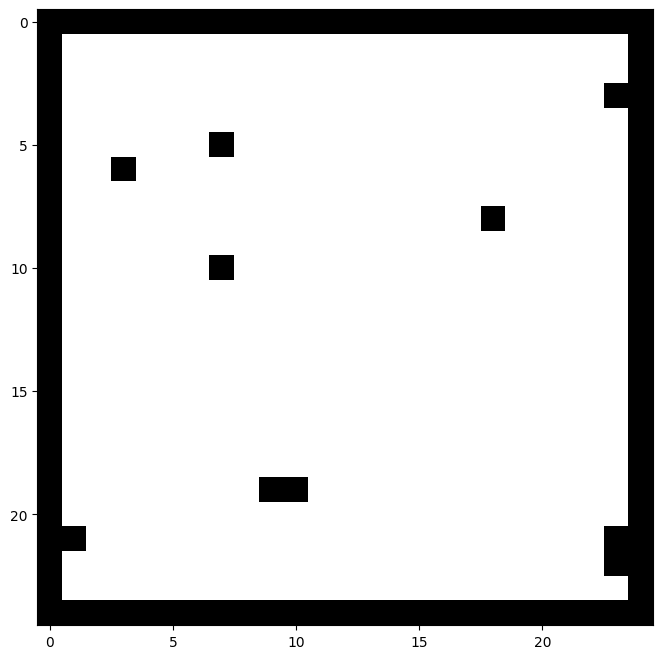

100%|██████████| 200/200 [00:01<00:00, 119.68it/s]


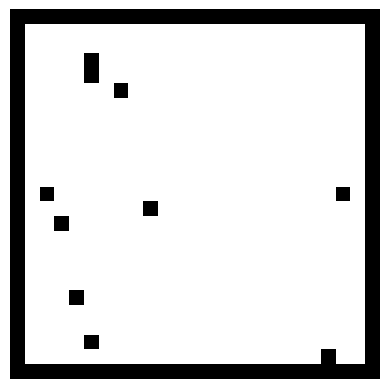

In [147]:
def turn_state(config):
    """
    A function to visualize the states
    """
    view_grid = np.copy(config)
    for i in range(len(config)):
        for j in range(len(config)):
            if type(config[i,j]) is not int:
                view_grid[i, j] = config[i,j].occupied
    view_grid = view_grid.astype(int)
    return view_grid

def build_animation(states, filename):
    fig = plt.figure()
    plt.axis('off')

    ims = []
    for state in states:
        im = plt.imshow(state, animated=True, cmap='binary')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=1000)
    ani.save(filename, writer='pillow')

# Main code
my_grid = initialize(rows,columns)
my_grid = fill_random(n_particles, my_grid)
observe(my_grid)

states = []
states.append(turn_state(my_grid))
next_grid = update(my_grid)
states.append(turn_state(next_grid))
states.append(turn_state(next_grid))

for i in tqdm(range(200)):
    next_grid = update(next_grid)
    states.append(turn_state(next_grid))

# Cambiar el nombre del archivo a .gif
build_animation(states, "video.gif")

## Main with grid

In [201]:
def turn_state(config):
    """
    A function to visualize the states
    """
    view_grid = np.copy(config)
    for i in range(len(config)):
        for j in range(len(config[0])):
            if type(config[i,j]) is not int:
                view_grid[i, j] = config[i,j].occupied
    view_grid = view_grid.astype(int)
    return view_grid

def build_animation(states, filename):
    fig, ax = plt.subplots()
    ax.axis('off')

    ims = []
    for state in states:
        im = ax.imshow(state, animated=True, cmap='binary')
        ims.append([im])

    # Drawing the grid
    rows, cols = states[0].shape
    for row in range(rows):
        ax.plot([0, cols-1], [row-0.5, row-0.5], 'k-', linewidth=0.5)
    for col in range(cols):
        ax.plot([col-0.5, col-0.5], [0, rows-1], 'k-', linewidth=0.5)

    ani = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=1000)
    ani.save(filename, writer='pillow')

# Main code
my_grid = initialize(rows,columns)
my_grid = fill_random(n_particles, my_grid)
#observe(my_grid)

states = []
states.append(turn_state(my_grid))
next_grid = update(my_grid)
states.append(turn_state(next_grid))
states.append(turn_state(next_grid))

for i in range(200):
    next_grid = update(next_grid)
    states.append(turn_state(next_grid))

# Cambiar el nombre del archivo a .gif
build_animation(states, "video_with_grid.gif")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()